# Intro

Simple agenda here: we're going to load the motifs/TFs mapping and then make some pretty histograms showing the mapping

In [2]:
# Load the data, ggplot/ggpubr, and dplyr
library(dplyr)
library(ggpubr)

tf.motifs <- readRDS("../../trenadb/fimo/2017_08_23_Motif_TF_Map.RDS")


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: ggplot2
Loading required package: magrittr


In [42]:
str(tf.motifs)

Classes ‘tbl_df’, ‘tbl’ and 'data.frame':	13240 obs. of  2 variables:
 $ Motif: chr  "Celegans-UniPROBE-Nsy_7.UP00402" "Cparvum-UniPROBE-Cgd2_3490.UP00395" "Ggallus-jaspar2016-LIN54-MA0619.1" "Ggallus-jaspar2016-MAFG::NFE2L1-MA0089.1" ...
 $ TF   : chr  "Nsy-7" "Cgd2_3490" "LIN54" "ATF2" ...


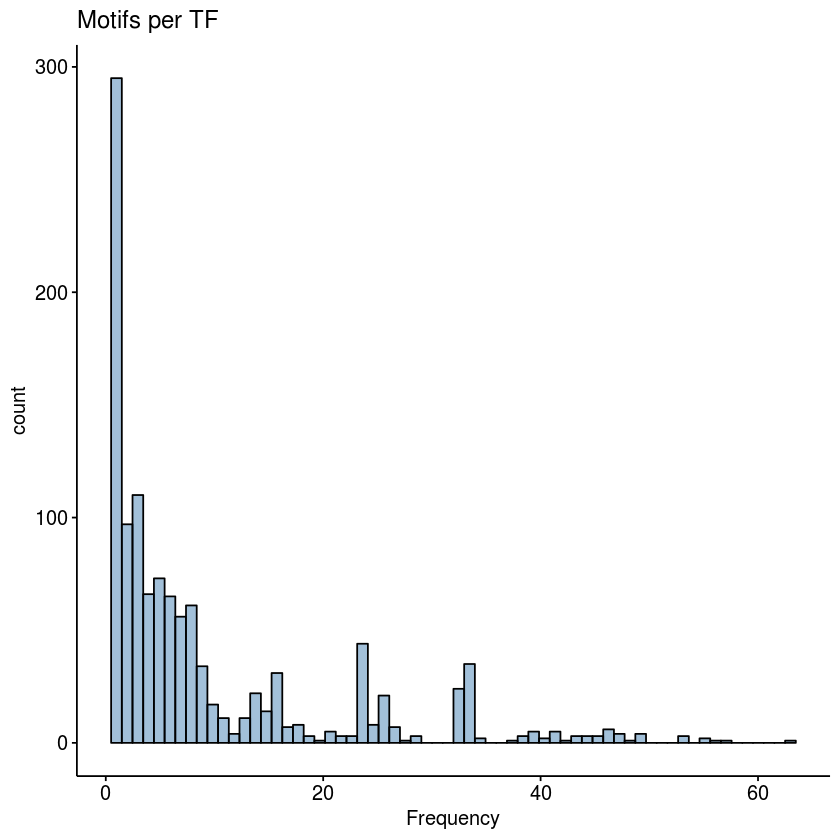

In [43]:
# Make a plot of just Jaspar motifs
tf.motifs %>% filter(grepl("jaspar2016",Motif)) %>%
    group_by(TF) %>%
    summarise(Frequency = n()) %>%
    arrange(desc(Frequency)) %>%
    gghistogram(x = "Frequency", 
                color = "black", 
                fill = "steelblue",
                bins = 64, 
                title = "Motifs per TF") -> motifs.per.tf
motifs.per.tf

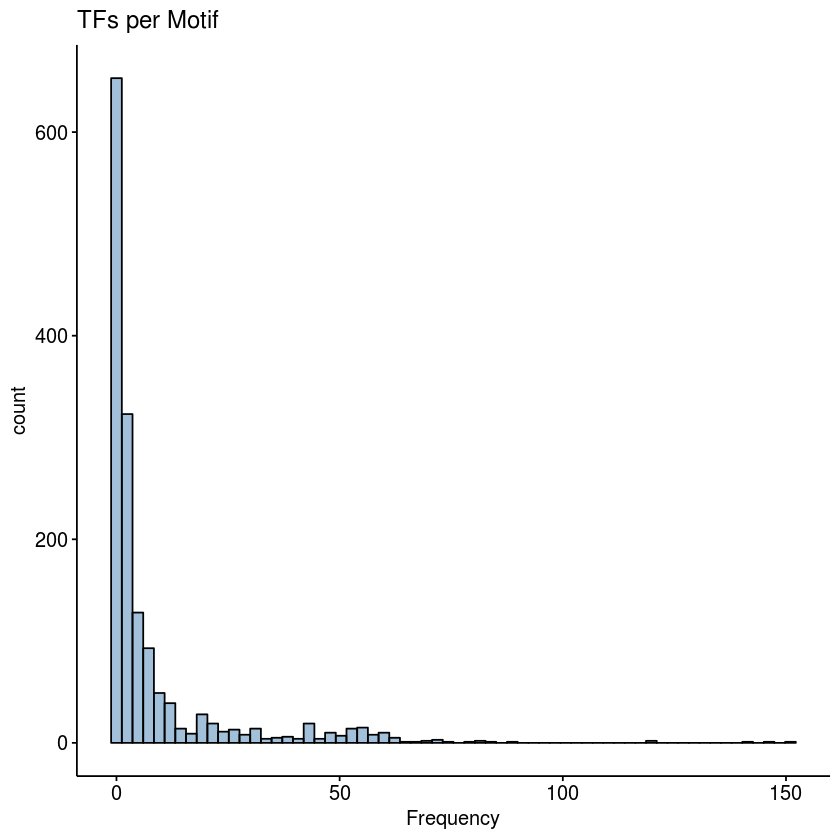

In [44]:
# Turn it around: how many TFs per motif?
# Make a plot of all TFs and their # of motifs
tf.motifs %>% group_by(Motif) %>%
    summarise(Frequency = n()) %>%
    arrange(desc(Frequency)) %>%
    gghistogram(x = "Frequency", 
                color = "black", 
                fill = "steelblue",
                bins = 64, 
                title = "TFs per Motif"
                ) -> tfs.per.motif
tfs.per.motif

In [45]:
# Save the figures
tfs.per.motif %>% ggexport(filename = "./tfsPerMotif.png")
motifs.per.tf %>% ggexport(filename = "./motifsPerTF.png")

file saved to ./tfsPerMotif.png
file saved to ./motifsPerTF.png


# Part 2: Tables of Sources

We've added 2 RDS files; let's make those into pretty tables too; we'll need to manually create a table to go with it


In [55]:
# Load the 2 RDS files 
expanded <- readRDS("../../trenadb/fimo/2017_10_26_Motif_TF_Map_Expanded.RDS")
collapsed <- readRDS("../../trenadb/fimo/2017_10_26_Motif_TF_Map_Collapsed.RDS")

motif.origins <- data_frame(Origin = c("jaspar2016", "HOCOMOCOv10","UniPROBE","SwissRegulon"),
                            Motifs = c(631, 1066, 380, 684), 
                           )

I want to also add a column to the dataframe; I want to know how many motifs in the FINAL dataset came from each database. I'll use a simple grep to do it:

In [56]:
unique.motifs <- unique(tf.motifs$Motif)
from.jasp <- sum(grepl("jaspar2016", unique.motifs))
from.hoco <- sum(grepl("HOCOMOCO", unique.motifs))
from.unip <- sum(grepl("UniPROBE", unique.motifs))
from.swis <- sum(grepl("SwissRegulon", unique.motifs))
motif.origins$Final.Motifs <- c(from.jasp, from.hoco, from.unip, from.swis)
motif.origins

Origin,Motifs,Final.Motifs
jaspar2016,631,631
HOCOMOCOv10,1066,649
UniPROBE,380,162
SwissRegulon,684,88


Just to check, here's the motifs and final motifs (should be 2761 and 1530, respectively)

In [57]:
sum(motif.origins$Motifs)
sum(motif.origins$Final.Motifs)

[1] 2761

[1] 1530

Now we want to join these with our other information. Let's create the information: a summary of how many TFs are from each source:

In [60]:
expanded %>% select(TF, Origin) %>%
  group_by(Origin) %>% 
  summarize(Total.Mappings = n(),
            Total.TFs = n_distinct(TF)) -> map.summary
map.summary

Origin,Total.Mappings,Total.TFs
HOCOMOCOv10,1679,604
jaspar2016,631,544
SwissRegulon,3835,684
TFClass,8570,762
UniPROBE,1104,363


A full join should give us what we want here:

In [61]:
motif.origins %>% full_join(map.summary, by = "Origin") -> Mapping.Table 
Mapping.Table

Origin,Motifs,Final.Motifs,Total.Mappings,Total.TFs
jaspar2016,631,631,631,544
HOCOMOCOv10,1066,649,1679,604
UniPROBE,380,162,1104,363
SwissRegulon,684,88,3835,684
TFClass,NA,NA,8570,762


Notes:

* Better column names
* Wrap column names
* Make it pretty!

In [63]:
# Bring in pretty table packages
# https://cran.r-project.org/web/packages/kableExtra/vignettes/awesome_table_in_html.html
library(knitr)
library(kableExtra)
library(formattable)

file saved to ./Motif_TF_Table.png


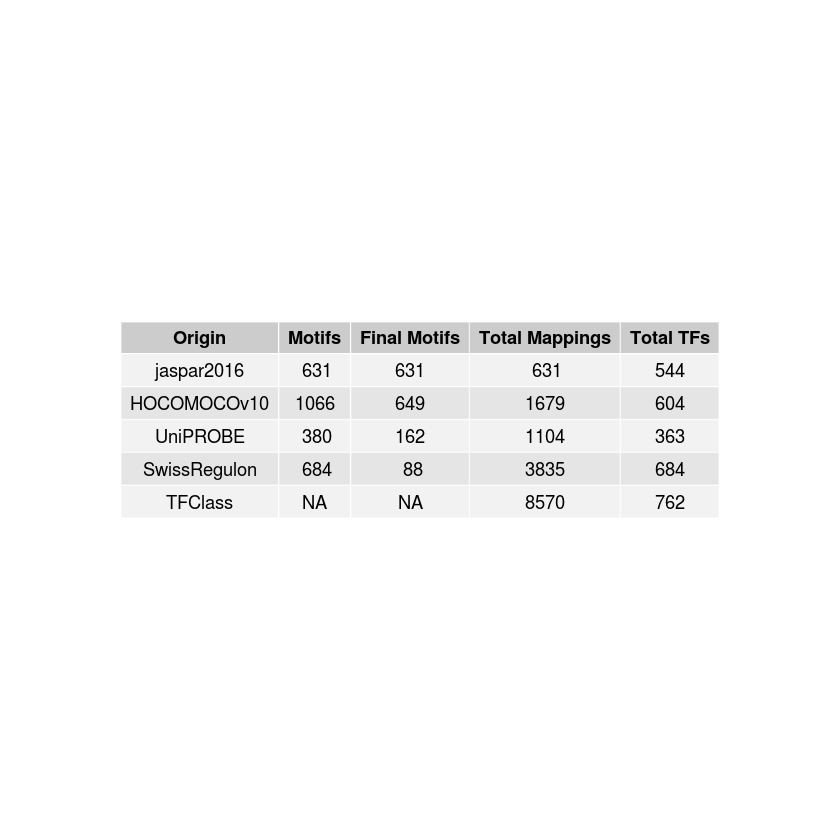

In [82]:
# Make table using ggpubr
library(ggpubr)
pretty.table1 <- ggtexttable(Mapping.Table, rows = NULL,
                             cols = c("Origin",
                                      "Motifs",
                                      "Final Motifs",
                                      "Total Mappings",
                                      "Total TFs"
                                     ))
pretty.table1
pretty.table1 %>% ggexport(filename = "./Motif_TF_Table.png")

In [4]:
collapsed.table <- readRDS("../../trenadb/fimo/2017_10_26_Motif_TF_Map_Collapsed.RDS")

origins <- collapsed.table%>% select(TF, Origin) %>%
  group_by(Origin) %>% 
  summarize(Total.Mappings = n(),
            Unique.TFs = n_distinct(TF))
head(origins)

Origin,Total.Mappings,Unique.TFs
HOCOMOCOv10,858,387
HOCOMOCOv10;jaspar2016,7,7
HOCOMOCOv10;jaspar2016;SwissRegulon,21,20
HOCOMOCOv10;jaspar2016;SwissRegulon;TFClass,81,81
HOCOMOCOv10;jaspar2016;TFClass,31,31
HOCOMOCOv10;SwissRegulon,363,211


file saved to ./Motif_Multiple_Origins.png


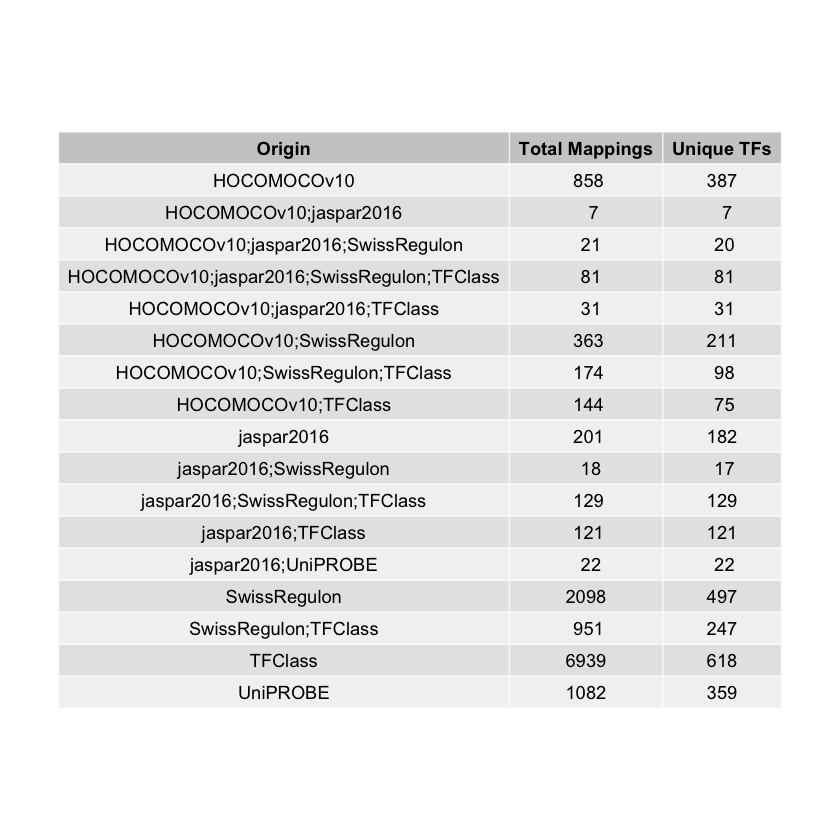

In [5]:
# Make another table with the origins

pretty.table2 <- ggtexttable(origins, rows = NULL,
                             cols = c("Origin",
                                      "Total Mappings",
                                      "Unique TFs"
                                     ))
pretty.table2
pretty.table2 %>% ggexport(filename = "./Motif_Multiple_Origins.png")